In [1]:
import importlib
import argparse
import os, sys
import argparse
import pandas as pd
import numpy as np
import pickle
import time

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc, precision_recall_curve


%matplotlib inline

In [3]:
import torch
import torch.utils.data
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler
from torch.autograd import Variable
from torchvision import transforms

In [4]:
sys.path.insert(0, './../utils/')
from utils import *
from models import *

In [5]:
#Define parser
name = 'bpi_2012'
#name = 'bpi_2013' 

parser = {
    'train': True,
    'test': True,
    'model_class': 'AE',
    'model_name': '',
    'data_dir': '../data/',
    'data_file': name + '.csv',
    'anomaly_pct': 0.05,
    'scaler': 'standardization',
    'input_dir': '../input/{}/'.format(name), 
    'batch_size' : 16,
    'epochs' : 100,
    'no_cuda' : False,
    'seed' : 7,
    'layer1': 1000,
    'layer2': 100,
    'lr': 0.0005,
    'betas': (0.9, 0.999),   
    'lr_decay': 0.90,
    'lr_step': 10,
}

args = argparse.Namespace(**parser)
args.output_dir = './output/{0}_{1}_{2}/'.format(name, args.anomaly_pct, args.model_class)

In [6]:
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

In [7]:
args.cuda = not args.no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 2, 'pin_memory': True} if args.cuda else {}

In [8]:
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [9]:
preprocessed_data_name = os.path.join(args.input_dir, 'preprocessed_data_{}.pkl'.format(args.anomaly_pct))
with open(preprocessed_data_name, 'rb') as f:
    input_train = pickle.load(f)
    input_val = pickle.load(f)
    input_test = pickle.load(f)
    pad_index_train = pickle.load(f)
    pad_index_val = pickle.load(f)
    pad_index_test = pickle.load(f)
    activity_label_test = pickle.load(f)
    time_label_test = pickle.load(f)
    train_case_num = pickle.load(f)
    val_case_num = pickle.load(f)
    test_case_num = pickle.load(f)
    train_row_num = pickle.load(f)
    val_row_num = pickle.load(f)
    test_row_num = pickle.load(f)
    min_value = pickle.load(f)
    max_value = pickle.load(f)
    mean_value = pickle.load(f)
    std_value = pickle.load(f)
    cols = pickle.load(f)
    statistics_storage = pickle.load(f)
    true_time = pickle.load(f)
    true_act = pickle.load(f)

# Load data

In [10]:
#train
input_trainLoader = torch.utils.data.DataLoader(input_train, batch_size=args.batch_size, shuffle=False, num_workers=2)
pad_index_trainLoader = torch.utils.data.DataLoader(pad_index_train, batch_size=args.batch_size, shuffle=False, num_workers=2)

In [11]:
#df
normal_df_name = os.path.join(args.input_dir, 'normal_df_{}.csv'.format(args.anomaly_pct))
normal_df = pd.read_csv(normal_df_name)

anomalous_df_name = os.path.join(args.input_dir, 'anomolous_df_{}.csv'.format(args.anomaly_pct))
anomalous_df = pd.read_csv(anomalous_df_name)

#test
caseid_test = normal_df['CaseID'][-test_row_num:]
normal_df_test = normal_df[-test_row_num:]
anomalous_df_test = anomalous_df[-test_row_num:]

In [12]:
normal_df.head()

,CaseID,Activity,CompleteTimestamp,Duration,CumDuration
0,1,A_SUBMITTED-COMPLETE,2011-10-01 07:38:44.546,0.000,0.000
1,1,A_PARTLYSUBMITTED-COMPLETE,2011-10-01 07:38:44.880,0.334,0.334
2,1,A_PREACCEPTED-COMPLETE,2011-10-01 07:39:37.906,53.026,53.360
3,1,W_Completeren aanvraag-SCHEDULE,2011-10-01 07:39:38.875,0.969,54.329
4,1,W_Completeren aanvraag-START,2011-10-01 18:36:46.437,39427.562,39481.891


In [13]:
anomalous_df.head()

,CaseID,AnomalousActivity,AnomalousCompleteTimestamp,AnomalousDuration,AnomalousCumDuration,ActivityLabel,TimeLabel
0,1,A_SUBMITTED-COMPLETE,2011-10-01 07:38:44.546000,0.000,0.000,0,1
1,1,A_PARTLYSUBMITTED-COMPLETE,2011-10-01 07:38:44.880000,0.334,0.334,0,0
2,1,A_PREACCEPTED-COMPLETE,2011-10-01 07:39:37.906000,53.026,53.360,0,0
3,1,W_Completeren aanvraag-SCHEDULE,2011-10-01 07:39:38.875000,0.969,54.329,0,0
4,1,O_ACCEPTED-COMPLETE,2011-10-01 18:36:46.437000,39427.562,39481.891,1,0


# Build model

## Define model

In [14]:
if args.model_class == 'AE':
    model = AE(input_train.shape, args.layer1, args.layer2)

if args.model_class == 'AE_tanh':
    model = AE_tanh(input_train.shape, args.layer1, args.layer2)

if args.cuda:
    model.cuda()

In [15]:
model

AE (
  (fc1): Linear (6475 -> 1000)
  (fc2): Linear (1000 -> 100)
  (fc3): Linear (100 -> 1000)
  (fc4): Linear (1000 -> 6475)
  (dout): Dropout (p = 0.2)
  (tanh): Tanh ()
)

## Define loss

In [16]:
def loss_function(recon_x, x, pad_index):
    MSE = F.mse_loss(recon_x*pad_index, x*pad_index, size_average=False) 
    #BCE = F.binary_cross_entropy(recon_x, x, weight=pad_index, size_average=False)
    return MSE

## Define optimizer

In [17]:
optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=args.betas)

In [18]:
#Adjust learning rate per epoch: http://pytorch.org/docs/master/optim.html?highlight=adam#how-to-adjust-learning-rate

# Method 1:

#lambda1 = lambda epoch: epoch // args.lr_step
lambda1 = lambda epoch: args.lr_decay ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

# Method 2:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

# Utils

In [19]:
def save_model(model, epoch, score):
    model_file = os.path.join(args.output_dir, 'model_{}_epoch{}_score{:.4f}.pth'.format(args.model_class, epoch, score))
    torch.save(model.state_dict(), model_file)

In [20]:
def load_model(model, model_name):
    model_file = os.path.join(args.output_dir, model_name)
    assert os.path.isfile(model_file), 'Error: no model found!'
    model_state = torch.load(model_file)
    model.load_state_dict(model_state)

In [21]:
def val(model, input_val, pad_index_val):
    model.eval()
    input_val = Variable(torch.Tensor(input_val).float())
    pad_index_val = Variable(torch.Tensor(pad_index_val).float())
    
    if args.cuda:
        input_val = input_val.cuda()
        pad_index_val = pad_index_val.cuda()
    
    recon_val = model(input_val)    
    loss = loss_function(recon_val, input_val, pad_index_val)
    return loss.data[0]/len(input_test.data)

# Train

In [22]:
def train(epoch, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (batch_data, batch_index) in enumerate(zip(input_trainLoader, pad_index_trainLoader)):
        
        batch_data = Variable(batch_data.float())
        batch_index = Variable(batch_index.float())

        if args.cuda:
            batch_data = batch_data.cuda()
            batch_index = batch_index.cuda()
            
        optimizer.zero_grad()
        
        recon_data = model(batch_data)
        
        loss = loss_function(recon_data, batch_data, batch_index)
        
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        
    return train_loss / len(input_trainLoader.dataset)

In [23]:
if args.train:
    for epoch in range(1, args.epochs + 1):
        init = time.time()
        
        #method 1 scheduler
        scheduler.step()
        
        train_loss = train(epoch, model, optimizer)
        end_train = time.time()
        val_score = val(model, input_val, pad_index_val)
        
        #if epoch == 1:
        #    current_best = val_score
        #    save_model(model, epoch, val_score)
        
        #else:
        #    if val_score < current_best:
        #        current_best = val_score
        #        save_model(model, epoch, val_score)
        
        #method 2 scheduler
        #scheduler.step()
        
        end = time.time()
        print('====> Epoch {} | Train time: {:.4f} ms| End time: {:.4f} ms | Train loss: {:.4f} | Val score: {:.4f}'.
              format(epoch, (end_train-init)*1000, (end-init)*1000, train_loss, val_score))
else:
    load_model(model, args.model_name)

====> Epoch 1 | Train time: 3309.7279 ms| End time: 4598.7966 ms | Train loss: 21.8514 | Val score: 13.4116
====> Epoch 2 | Train time: 3204.3219 ms| End time: 4496.7890 ms | Train loss: 14.4329 | Val score: 11.6052
====> Epoch 3 | Train time: 3199.3632 ms| End time: 4512.3024 ms | Train loss: 12.5115 | Val score: 11.7825
====> Epoch 4 | Train time: 3203.1019 ms| End time: 4502.2354 ms | Train loss: 11.6896 | Val score: 10.9517
====> Epoch 5 | Train time: 3202.9181 ms| End time: 4491.1323 ms | Train loss: 10.7953 | Val score: 10.9220
====> Epoch 6 | Train time: 3200.8026 ms| End time: 4501.5516 ms | Train loss: 10.2981 | Val score: 9.9519
====> Epoch 7 | Train time: 3206.5434 ms| End time: 4496.7620 ms | Train loss: 9.5366 | Val score: 9.4529
====> Epoch 8 | Train time: 3196.1296 ms| End time: 4498.7407 ms | Train loss: 8.9312 | Val score: 9.4909
====> Epoch 9 | Train time: 3195.7965 ms| End time: 4509.3601 ms | Train loss: 8.6512 | Val score: 9.0065
====> Epoch 10 | Train time: 3203.5

====> Epoch 78 | Train time: 3203.1584 ms| End time: 4501.3151 ms | Train loss: 5.8609 | Val score: 7.2952
====> Epoch 79 | Train time: 3203.8233 ms| End time: 4507.8335 ms | Train loss: 5.8649 | Val score: 7.2949
====> Epoch 80 | Train time: 3196.8164 ms| End time: 4505.3794 ms | Train loss: 5.8641 | Val score: 7.2947
====> Epoch 81 | Train time: 3203.7730 ms| End time: 4504.8192 ms | Train loss: 5.8599 | Val score: 7.2939
====> Epoch 82 | Train time: 3195.4956 ms| End time: 4501.1649 ms | Train loss: 5.8572 | Val score: 7.2956
====> Epoch 83 | Train time: 3201.4427 ms| End time: 4504.4982 ms | Train loss: 5.8472 | Val score: 7.2949
====> Epoch 84 | Train time: 3200.4061 ms| End time: 4488.9975 ms | Train loss: 5.8643 | Val score: 7.2937
====> Epoch 85 | Train time: 3206.6422 ms| End time: 4516.3341 ms | Train loss: 5.8652 | Val score: 7.2945
====> Epoch 86 | Train time: 3200.1252 ms| End time: 4494.2360 ms | Train loss: 5.8588 | Val score: 7.2944
====> Epoch 87 | Train time: 3209.740

# Predict

In [24]:
if args.test:
    input_test = Variable(torch.Tensor(input_test).float())
    if args.cuda:
        input_test = input_test.cuda()
    
    print('Predicting...')
    recon_test = model(input_test)
    
    print('Separating prediction ...')
    predicted_time, predicted_activity = getPrediction(recon_test, pad_index_test)
    
    print('Done!')

Predicting...
Separating prediction ...
Done!


# Evaluate

## Time

In [25]:
#Fix predicted time
time_df = pd.DataFrame({'CaseID': caseid_test,
                        'PredictedTime': predicted_time})

groupByCase = time_df.groupby(['CaseID'])
fixed_time_df = pd.DataFrame(columns=list(time_df))

for case, group in groupByCase:
    group.iloc[0, 1] = -mean_value/std_value
    fixed_time_df = fixed_time_df.append(group)

/home/pllab/miniconda2/envs/pydata/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [26]:
fixed_time_df.head()

,CaseID,PredictedTime
214377,10470,-0.714593
214378,10470,-0.716766
214379,10470,-0.716655
214380,10471,-0.714593
214381,10471,-0.704945


In [27]:
fixed_predicted_time = fixed_time_df['PredictedTime']

In [28]:
error = np.abs(true_time - fixed_predicted_time)
error_time_df = pd.DataFrame({'Error': error,
                              'TimeLabel': time_label_test})

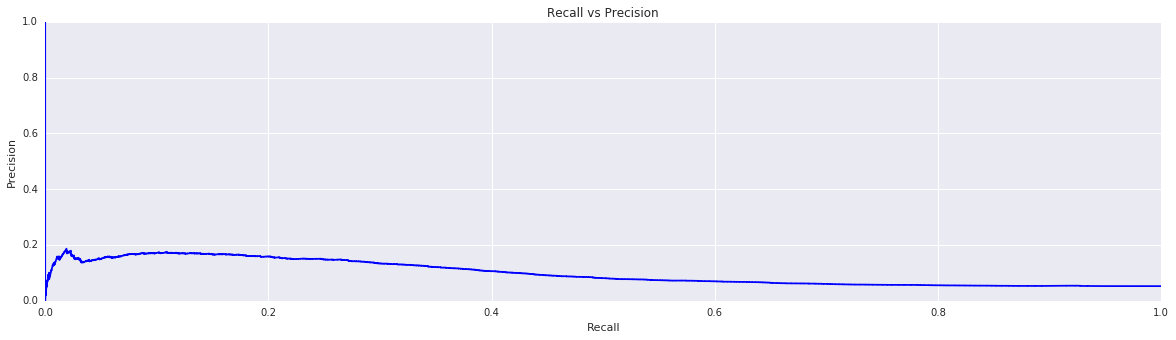

In [29]:
precision, recall, th = precision_recall_curve(error_time_df.TimeLabel, error_time_df.Error, pos_label=1)
plt.figure(figsize=(20, 5))
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [30]:
time_threshold = np.mean(error_time_df['Error'])
print('Threshold of Time: {}'.format(time_threshold))

Threshold of Time: 0.09430626113351404


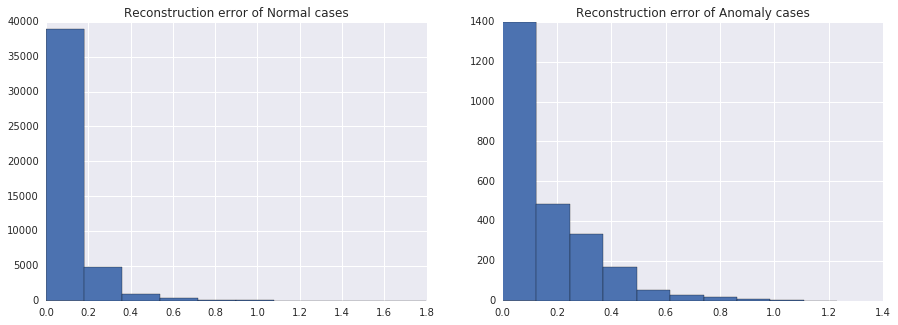

In [31]:
plotReconstructionError(error_time_df, variable='Time')

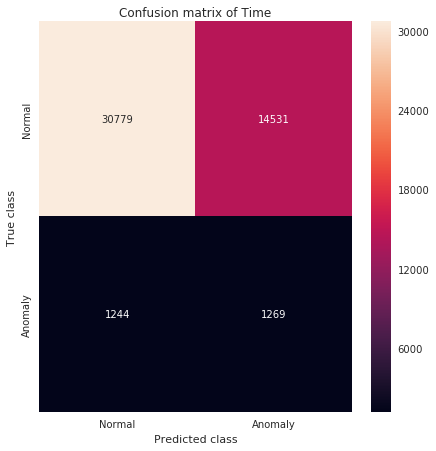

In [32]:
plotConfusionMaxtrix(error_time_df, threshold=time_threshold, variable='Time')

In [33]:
evalScore(error_time_df, threshold=time_threshold, variable='Time')

-------Evaluation of Time-------


--Weighted Evaluation--
Evaluation of Time
Precision: 0.91
Recall: 0.67
Fscore: 0.76


--Evaluation for each class--
Normal
Precision: 0.96
Recall: 0.68
Fscore: 0.80


Anomaly
Precision: 0.08
Recall: 0.50
Fscore: 0.14


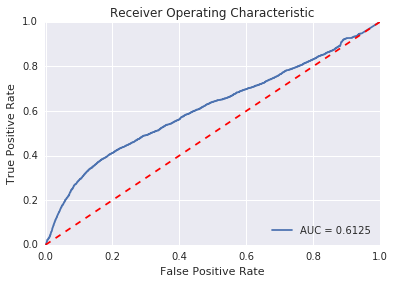

In [34]:
fpr, tpr, thresholds = roc_curve(error_time_df.TimeLabel, error_time_df.Error, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [35]:
#get submission
if args.scaler == 'standardization':
    inverse_scaled_time = [x*std_value+mean_value for x in fixed_predicted_time]
else:
    inverse_scaled_time = [x*(max_value-min_value)+min_value for x in fixed_predicted_time]
    
predicted_time_label_test = [1 if e > time_threshold else 0 for e in error_time_df.Error.values]

submission_time = pd.DataFrame({'AnomalousDuration': anomalous_df_test['AnomalousDuration'].copy(),
                                'Activity': normal_df_test['Activity'].copy(),
                                'AnomalousCumDuration': anomalous_df_test['AnomalousCumDuration'].copy(),
                                'PredictedCumDuration': inverse_scaled_time,
                                'TimeLabel': time_label_test,
                                'PredictedTimeLabel': predicted_time_label_test})

In [36]:
submission_time.head()

,Activity,AnomalousCumDuration,AnomalousDuration,PredictedCumDuration,PredictedTimeLabel,TimeLabel
214377,A_SUBMITTED-COMPLETE,0.000,0.000,0.000000,0,0
214378,A_PARTLYSUBMITTED-COMPLETE,0.276,0.276,-2123.099335,0,0
214379,A_DECLINED-COMPLETE,31.917,31.641,-2013.877368,0,0
214380,A_SUBMITTED-COMPLETE,0.000,0.000,0.000000,0,0
214381,A_PARTLYSUBMITTED-COMPLETE,0.555,0.555,9423.455684,0,0


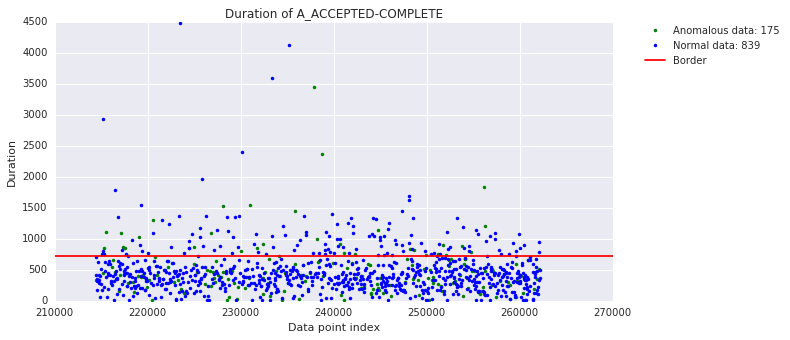

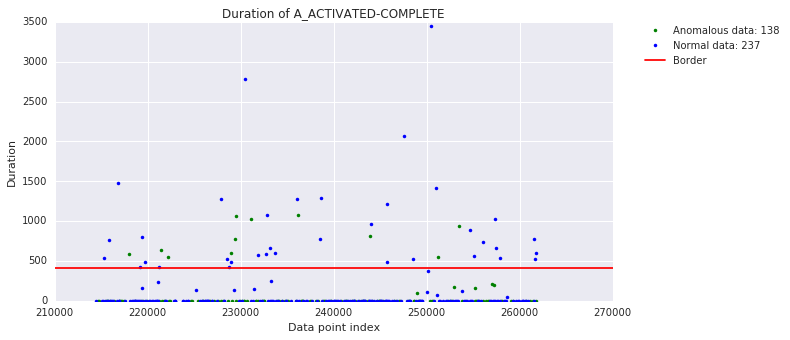

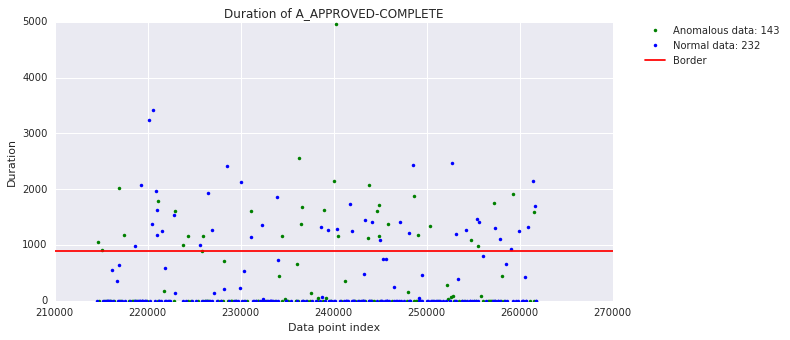

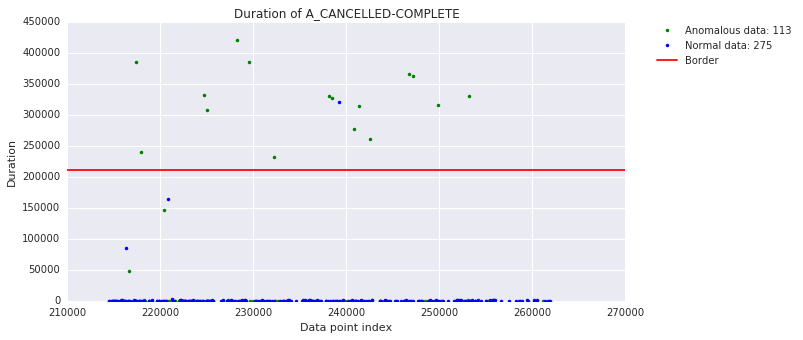

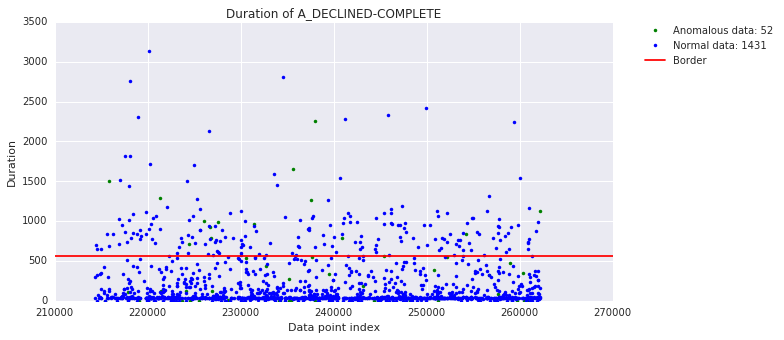

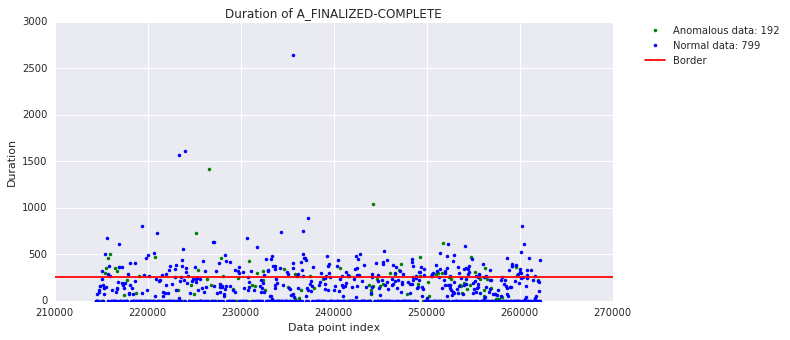

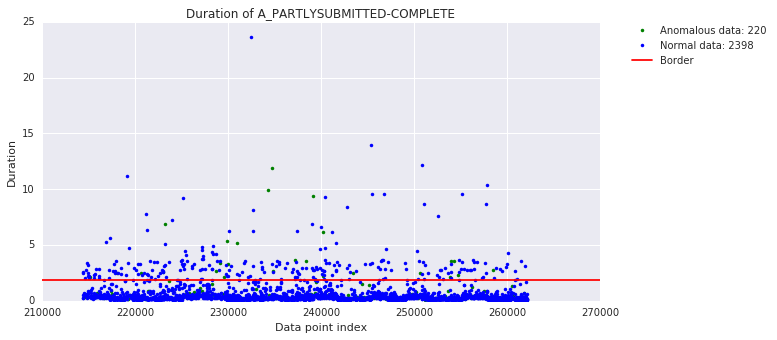

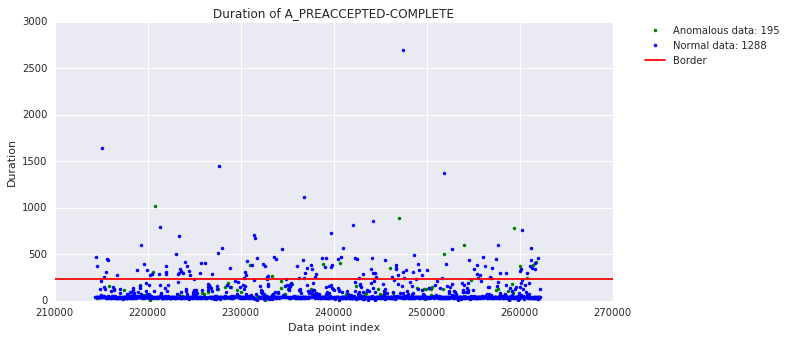

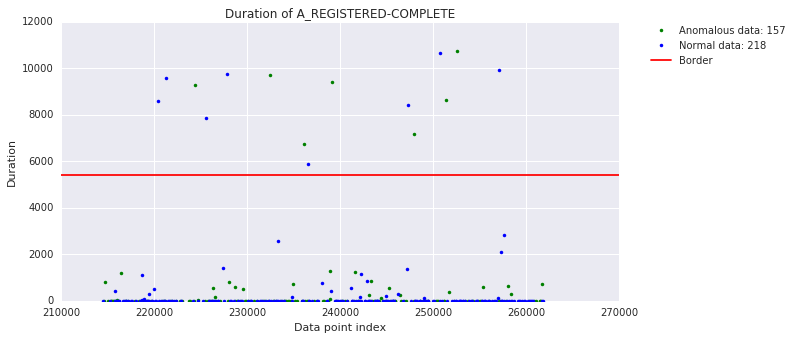

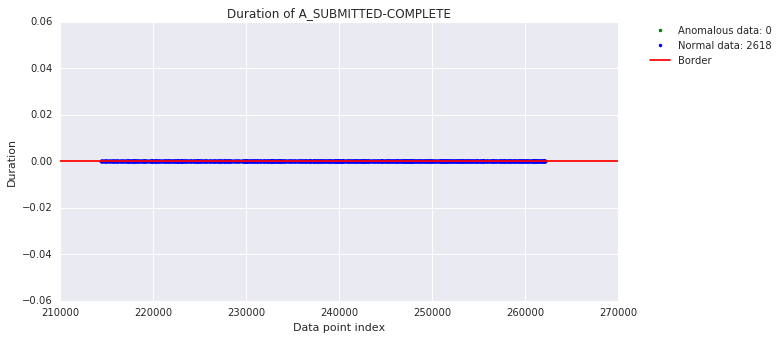

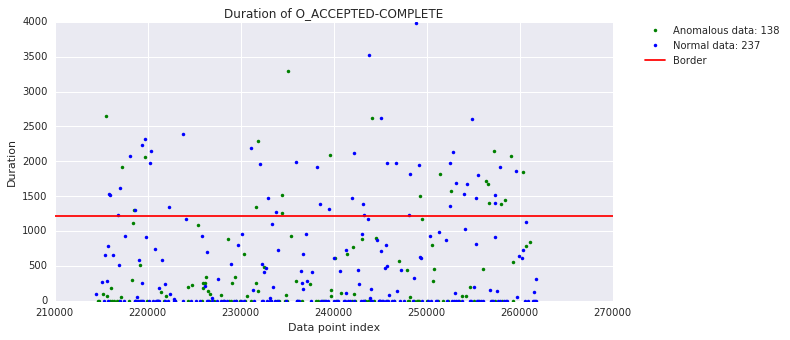

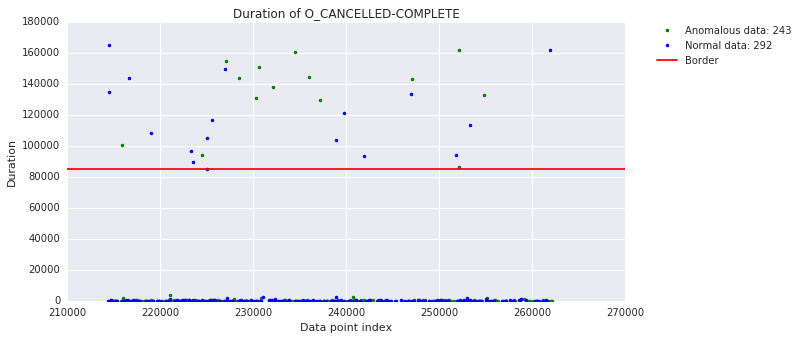

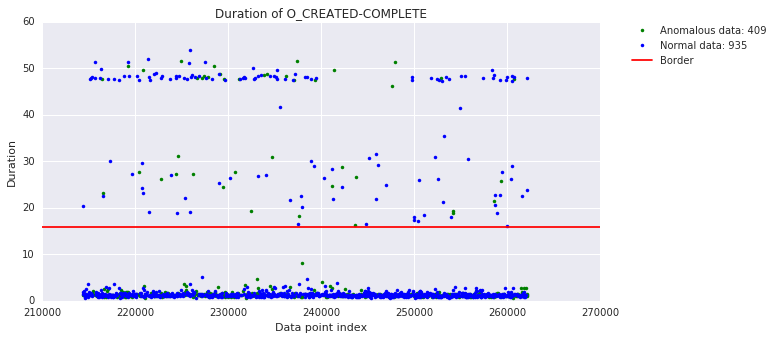

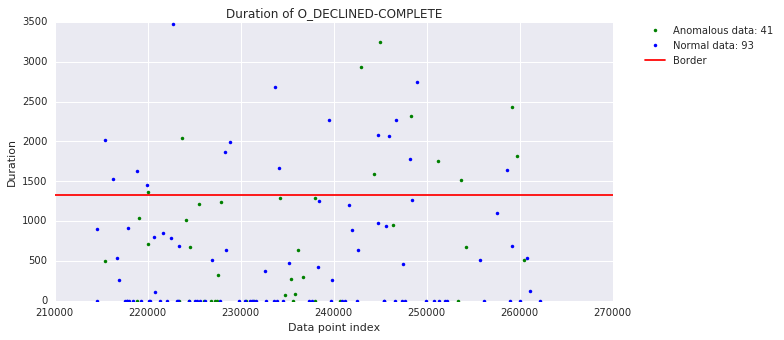

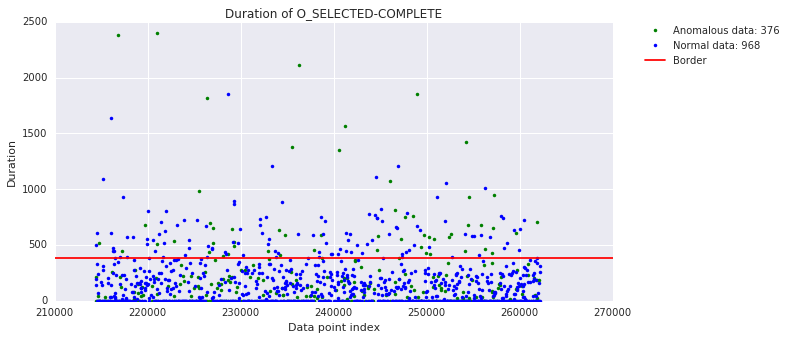

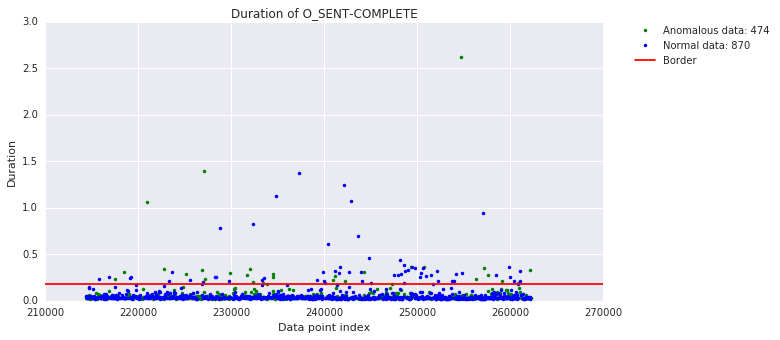

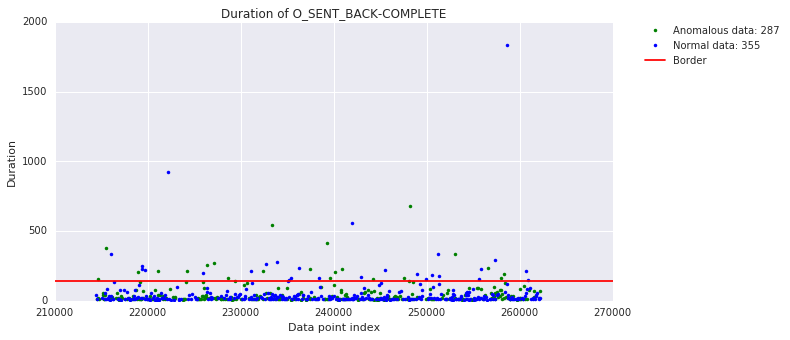

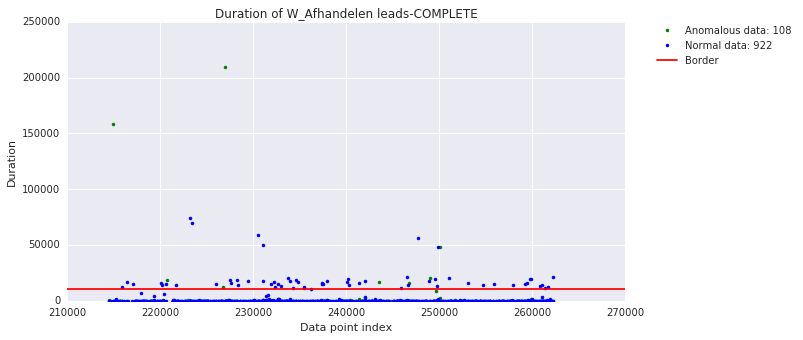

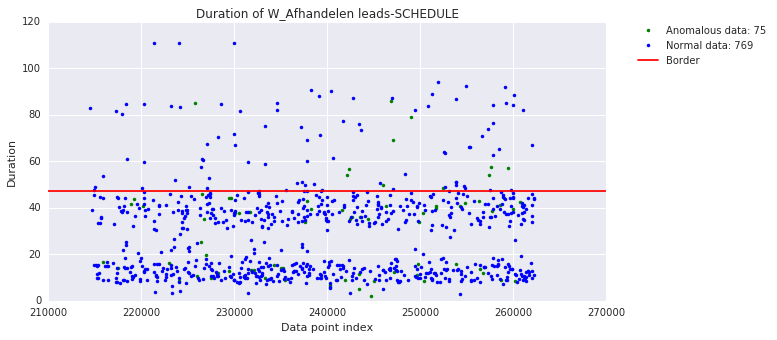

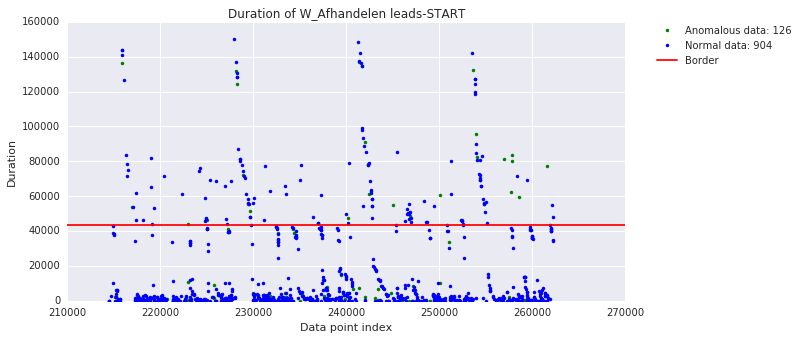

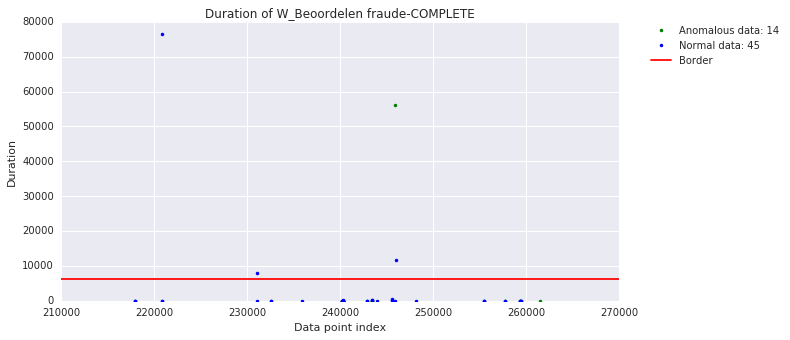

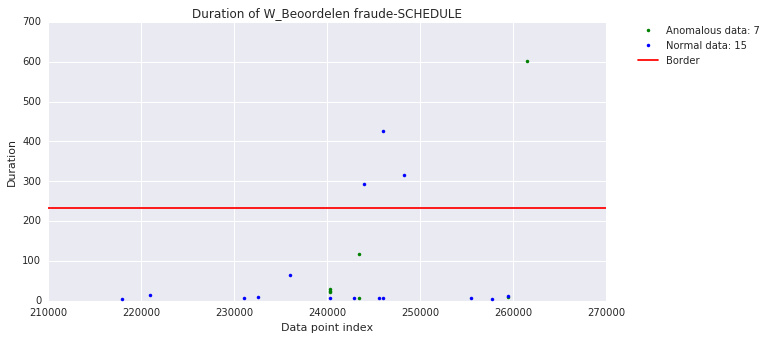

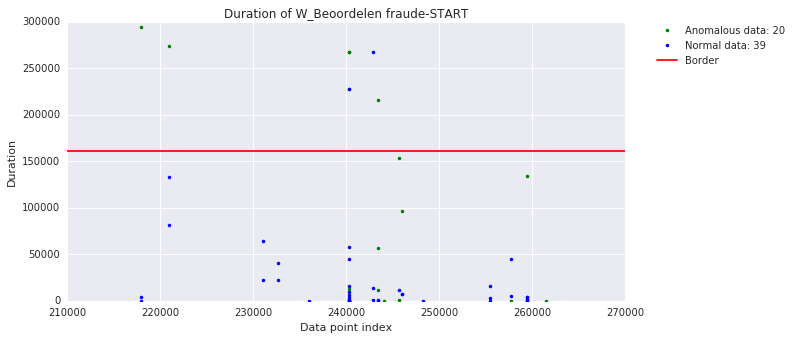

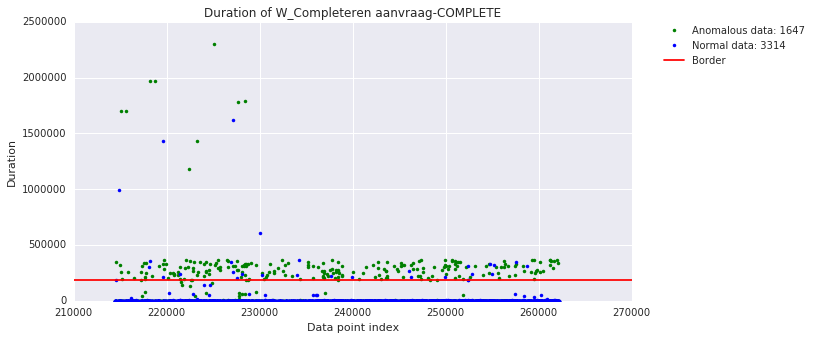

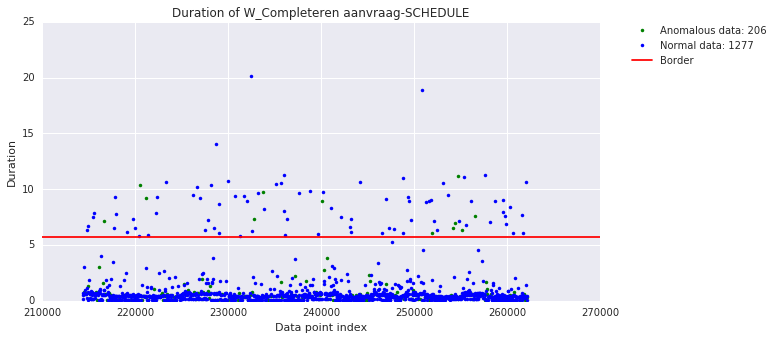

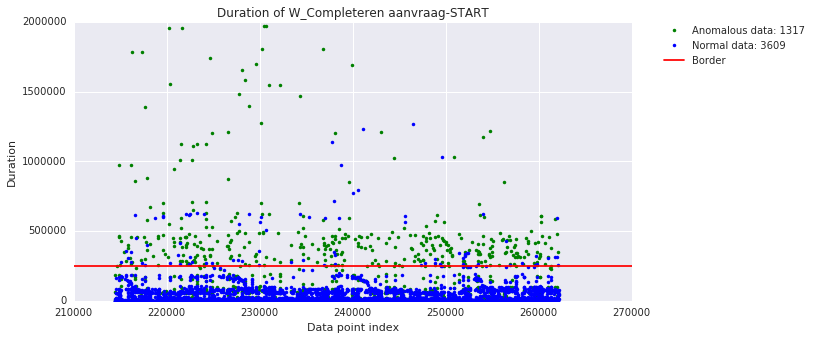

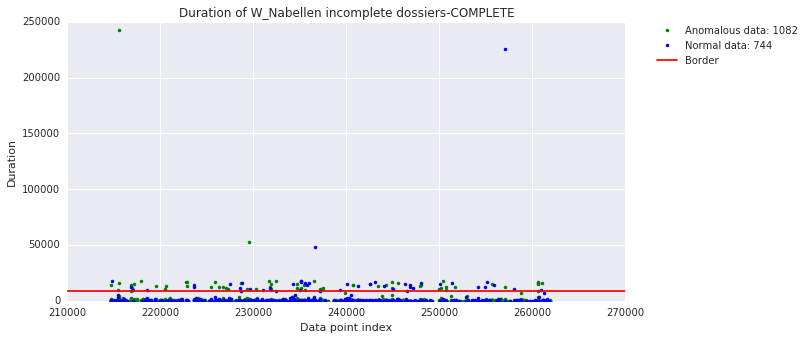

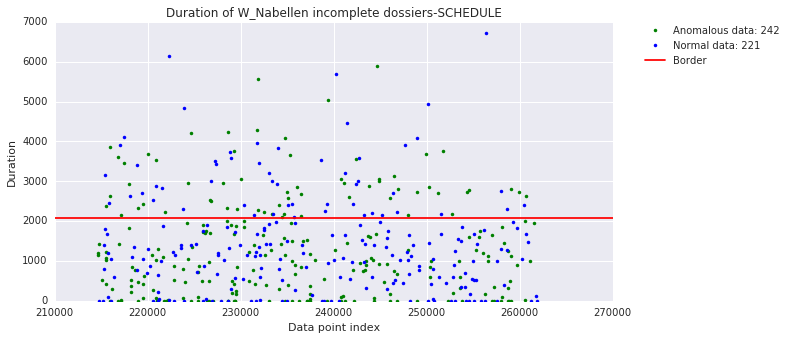

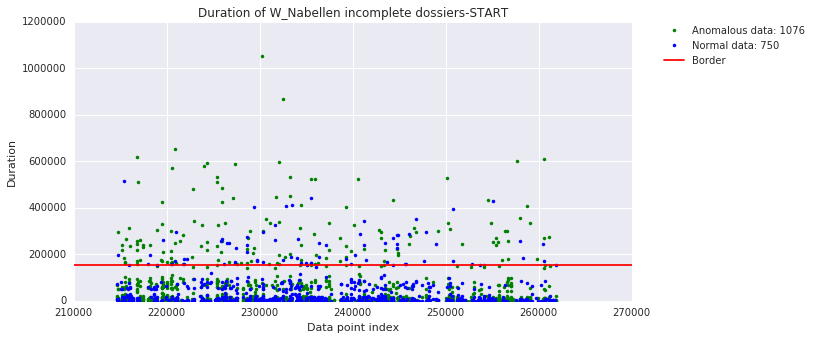

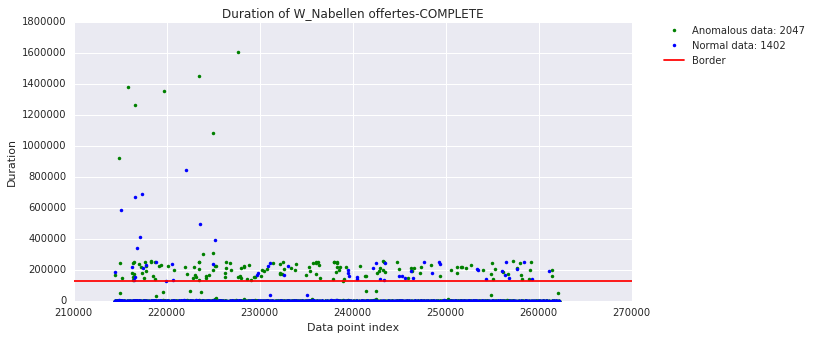

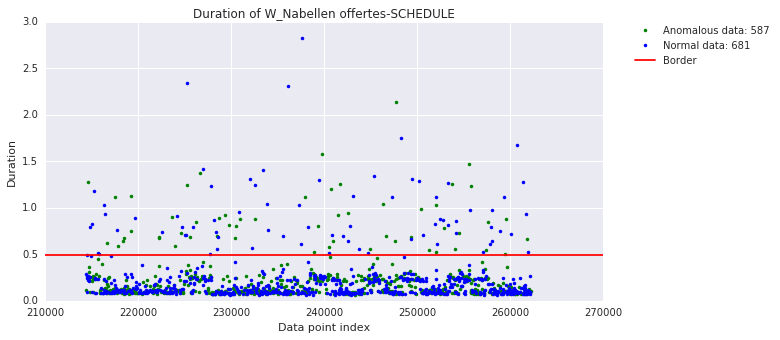

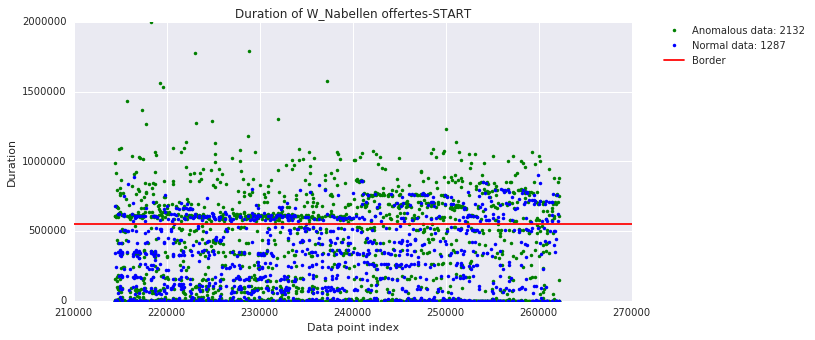

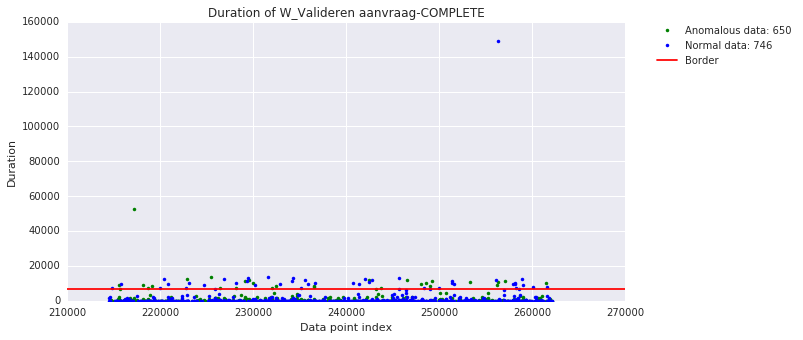

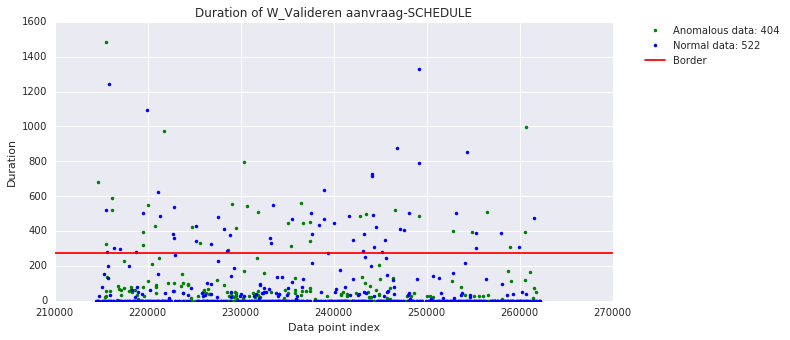

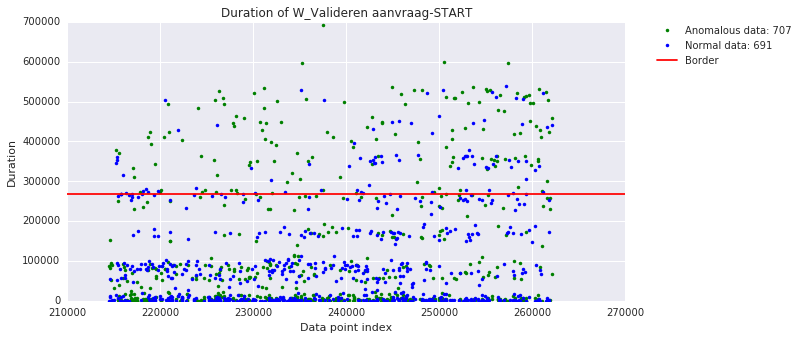

In [37]:
groupByActivity = submission_time.groupby(['Activity'])

for act, group in groupByActivity:
    plotDurationofPredictedTimeLabel(act, group, statistics_storage, False)

In [38]:
submission_time.head()

,Activity,AnomalousCumDuration,AnomalousDuration,PredictedCumDuration,PredictedTimeLabel,TimeLabel
214377,A_SUBMITTED-COMPLETE,0.000,0.000,0.000000,0,0
214378,A_PARTLYSUBMITTED-COMPLETE,0.276,0.276,-2123.099335,0,0
214379,A_DECLINED-COMPLETE,31.917,31.641,-2013.877368,0,0
214380,A_SUBMITTED-COMPLETE,0.000,0.000,0.000000,0,0
214381,A_PARTLYSUBMITTED-COMPLETE,0.555,0.555,9423.455684,0,0


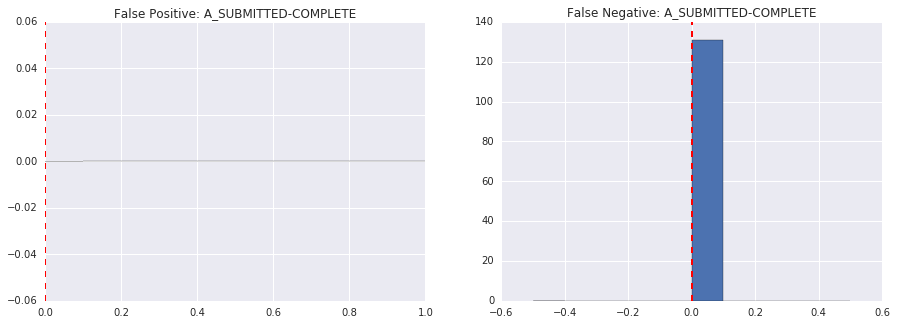

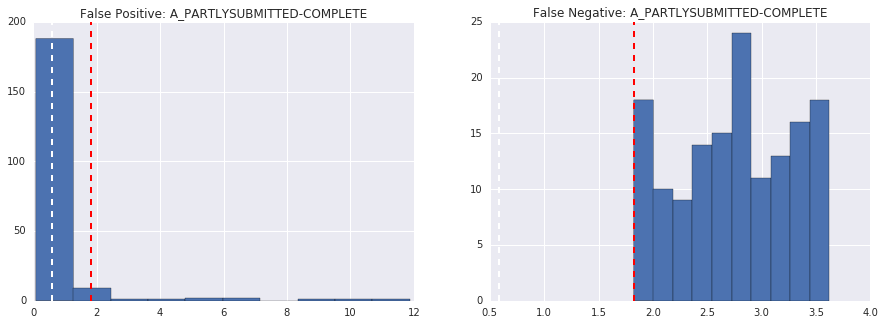

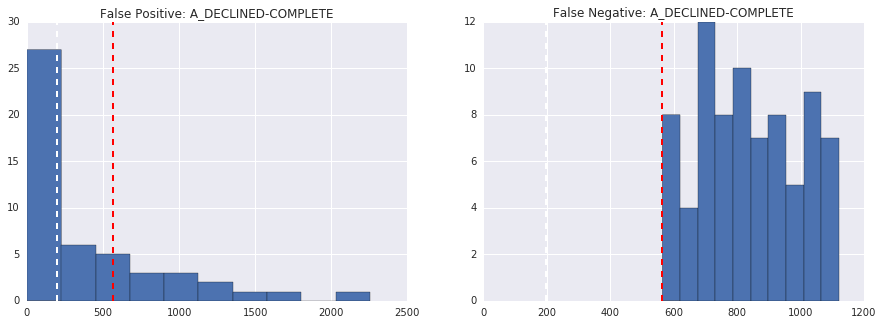

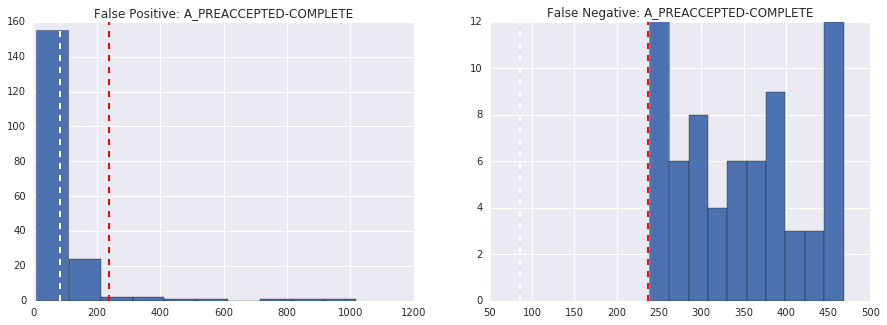

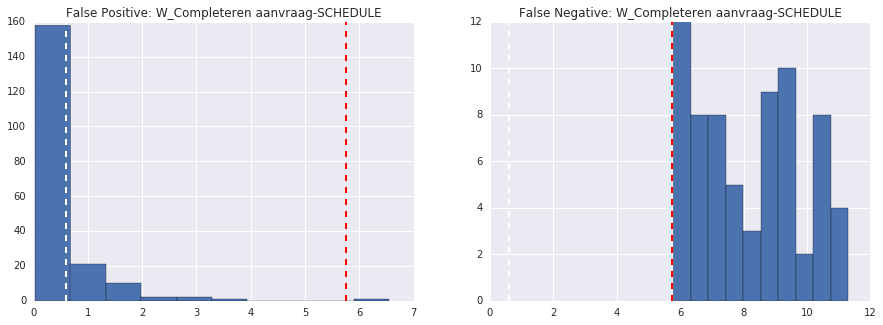

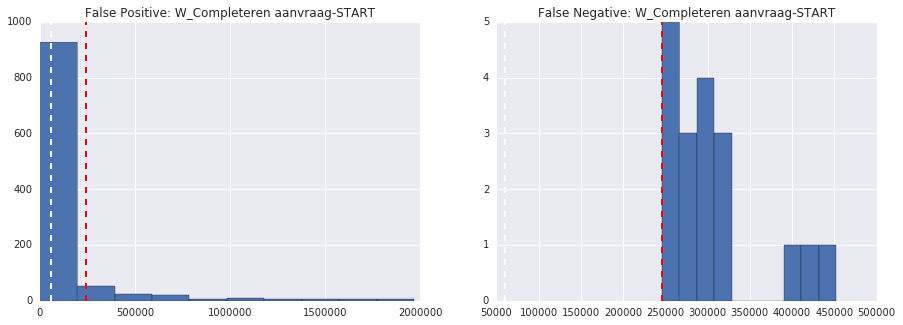

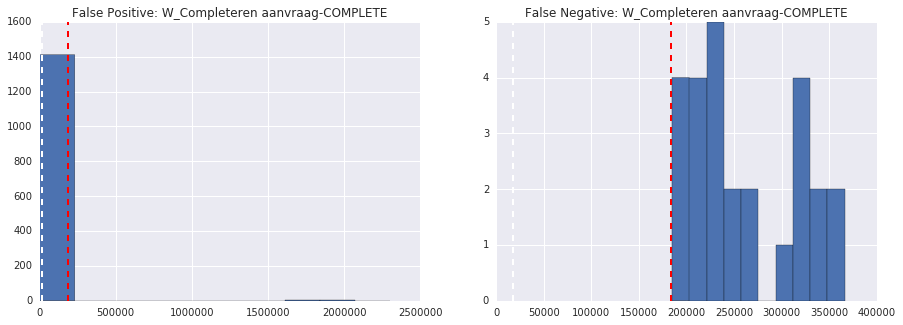

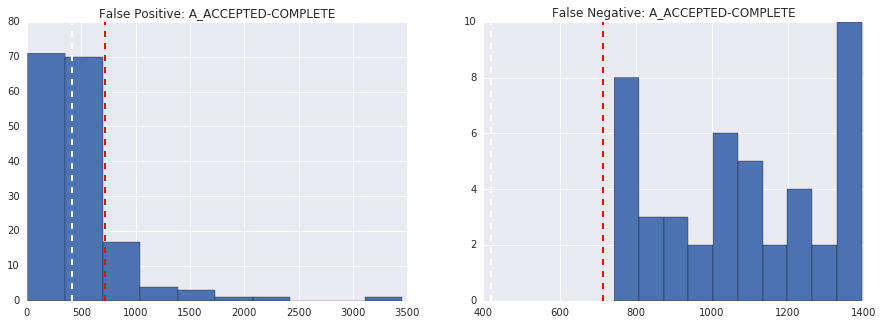

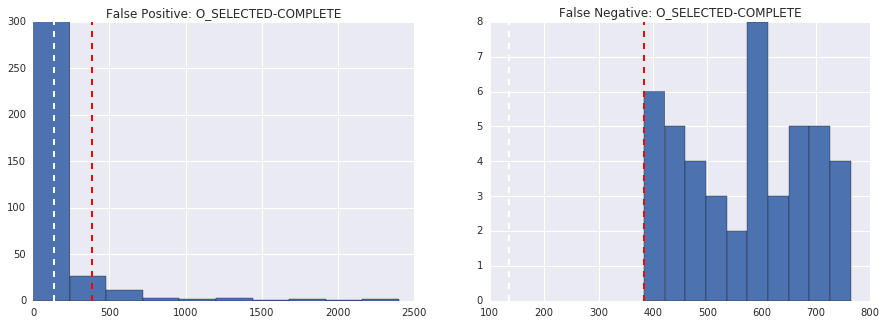

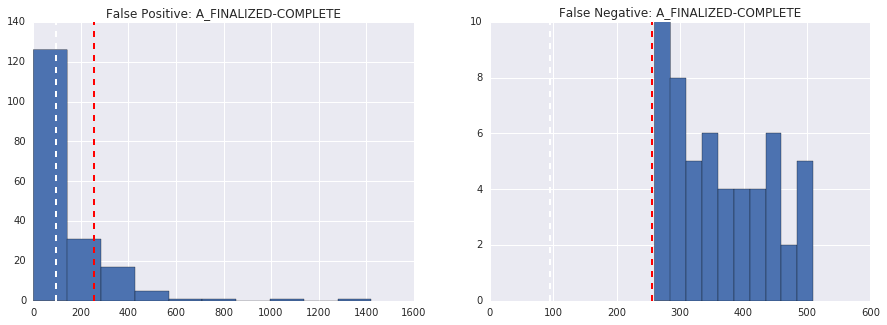

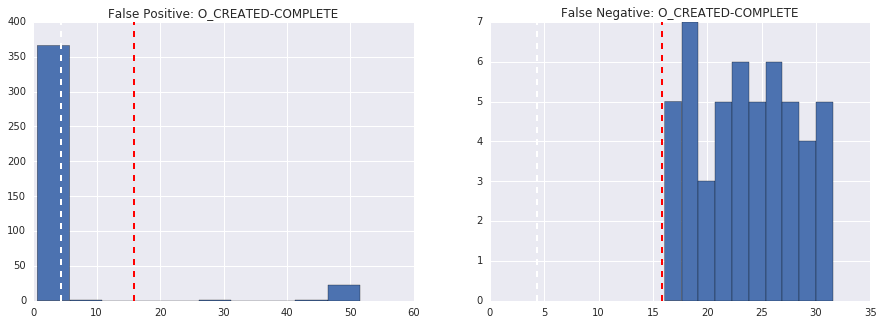

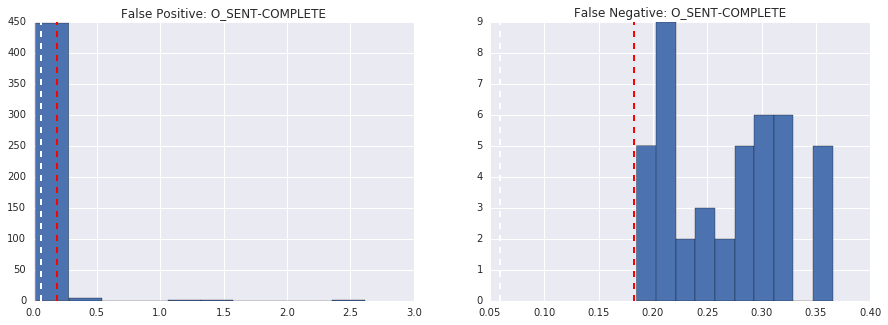

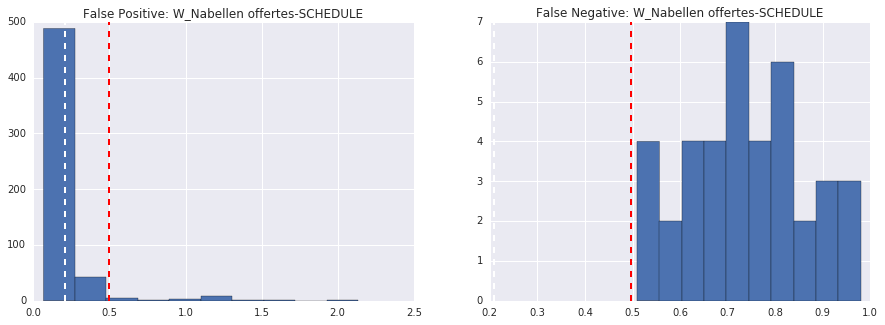

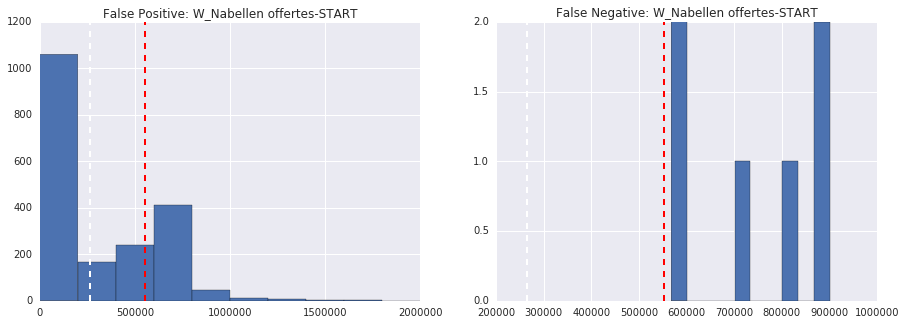

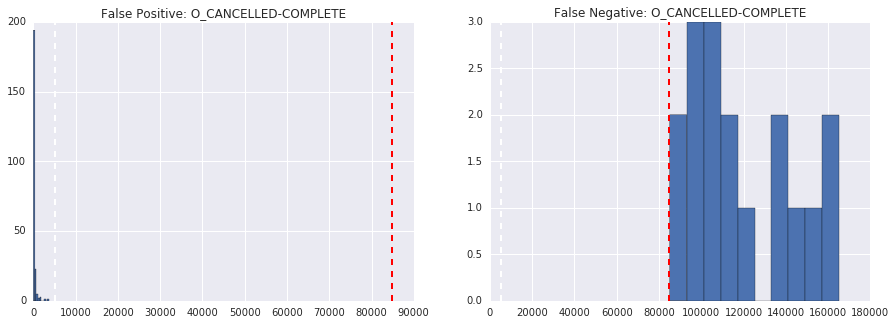

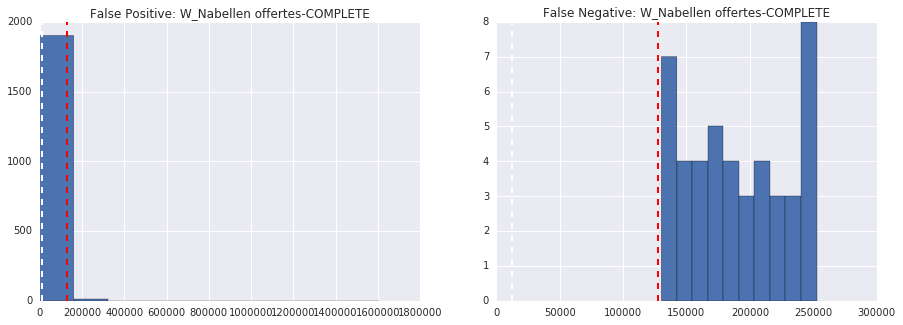

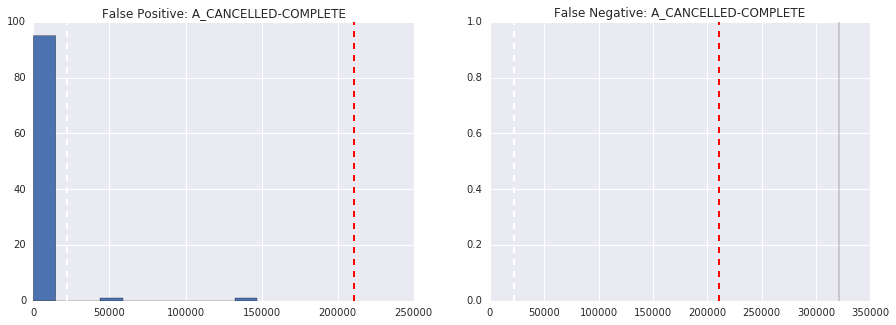

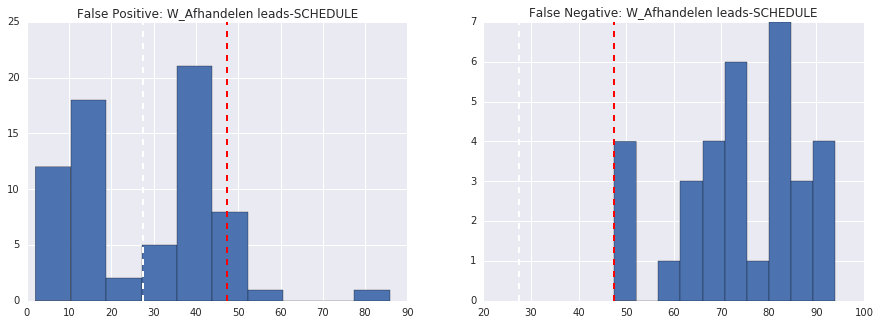

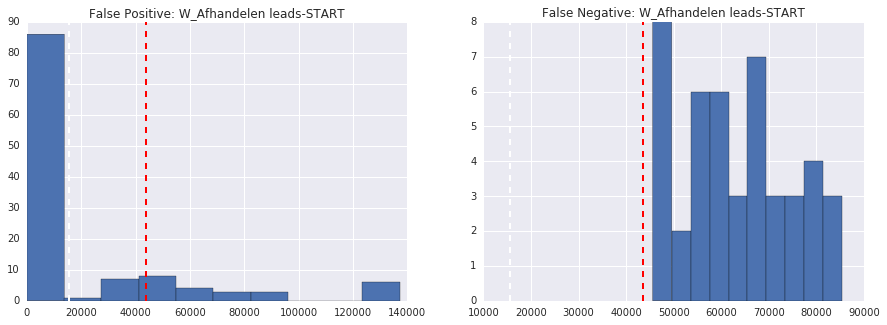

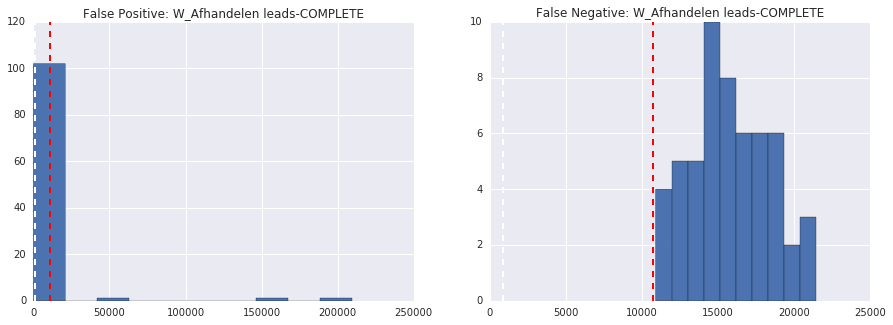

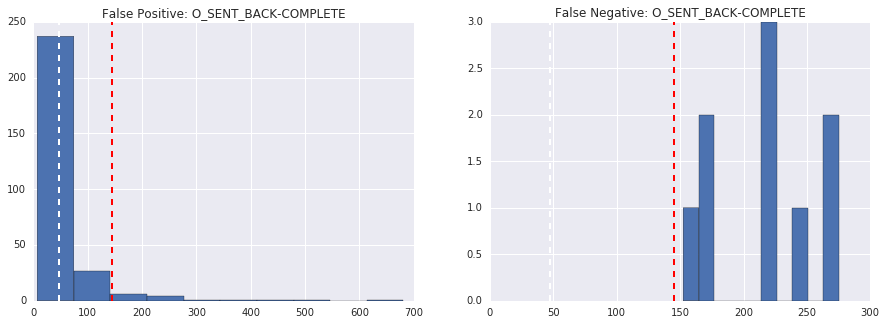

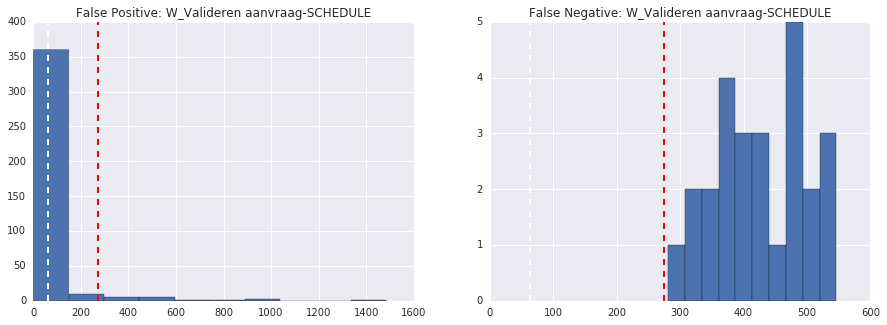

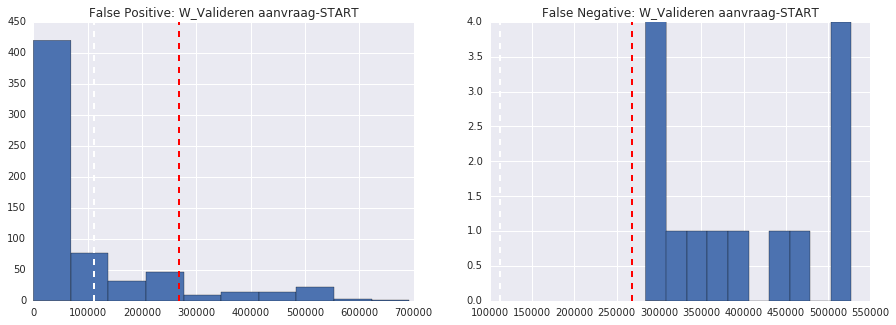

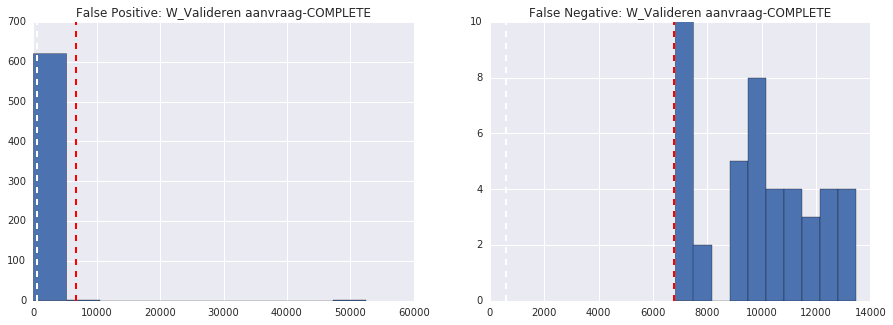

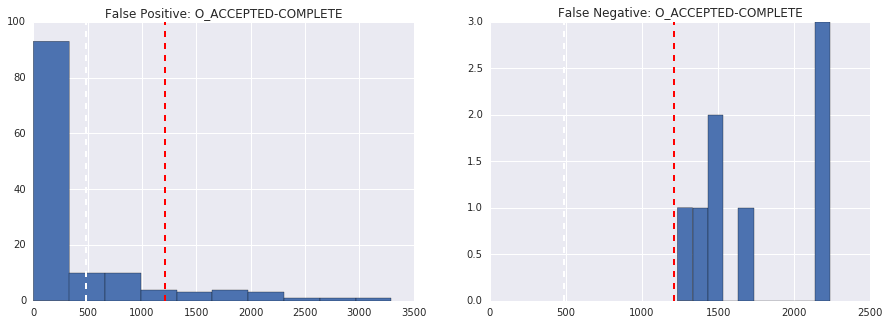

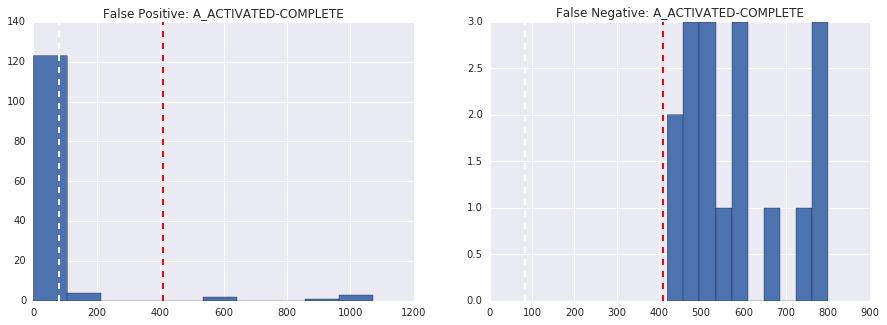

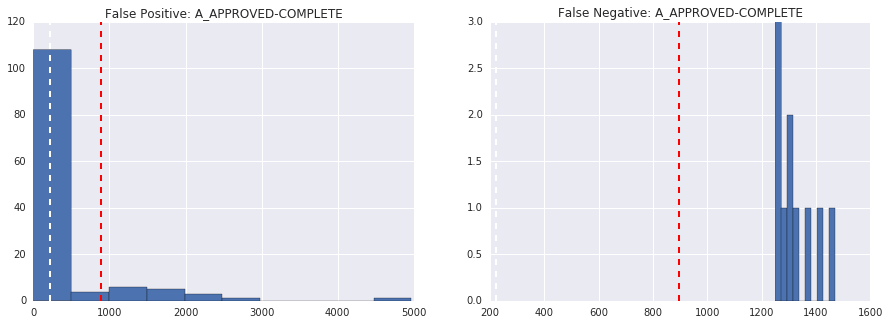

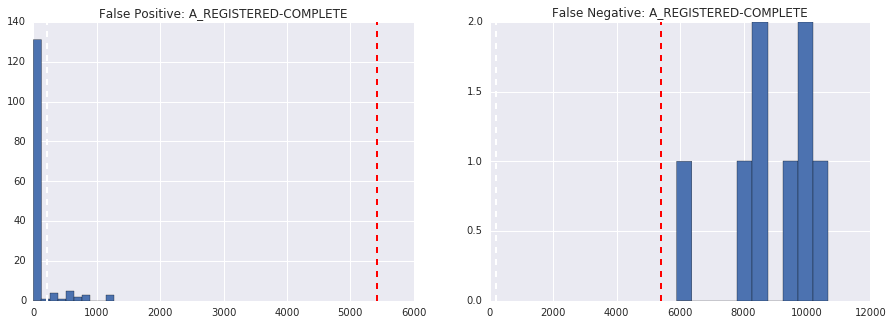

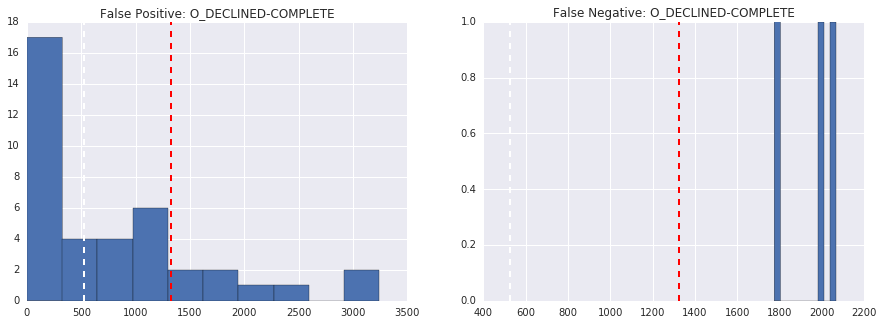

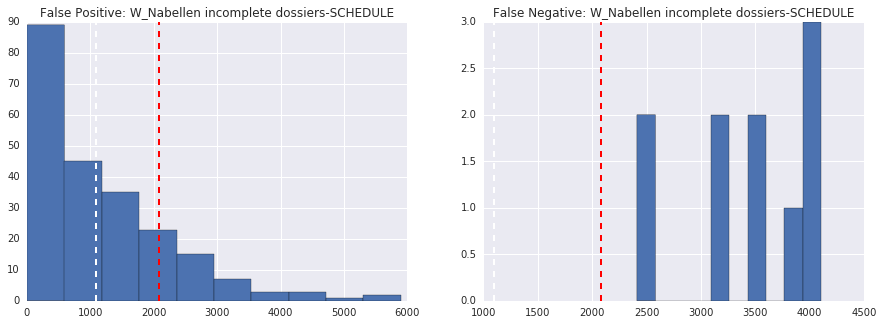

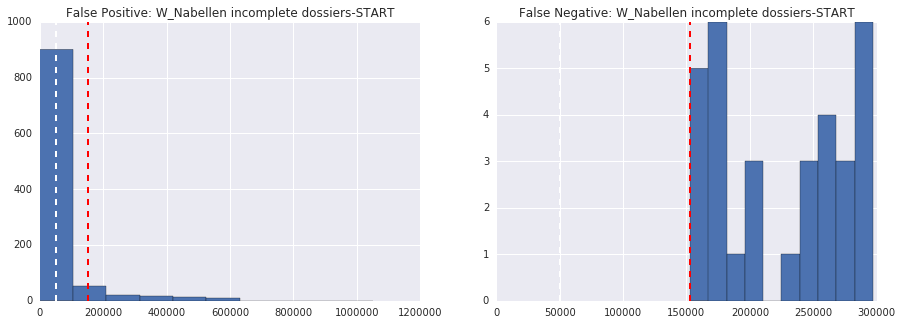

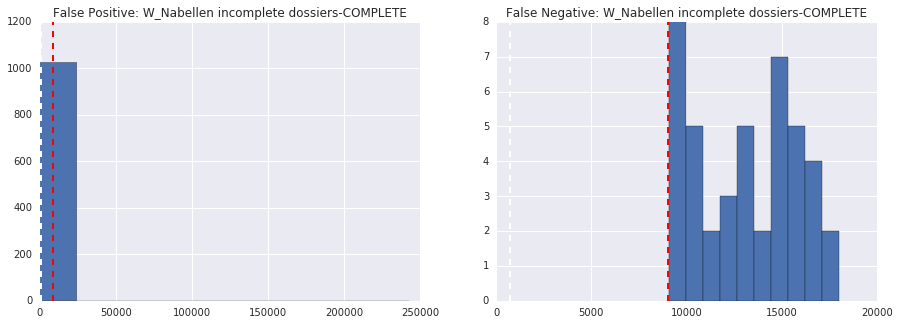

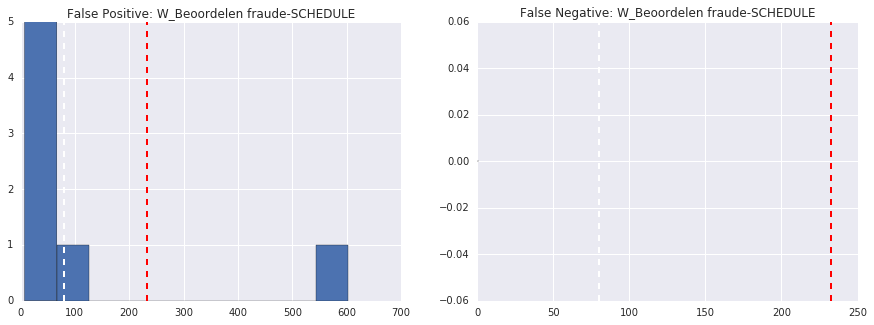

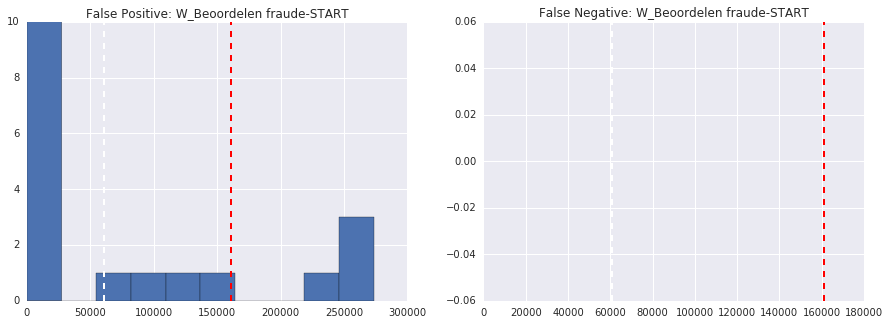

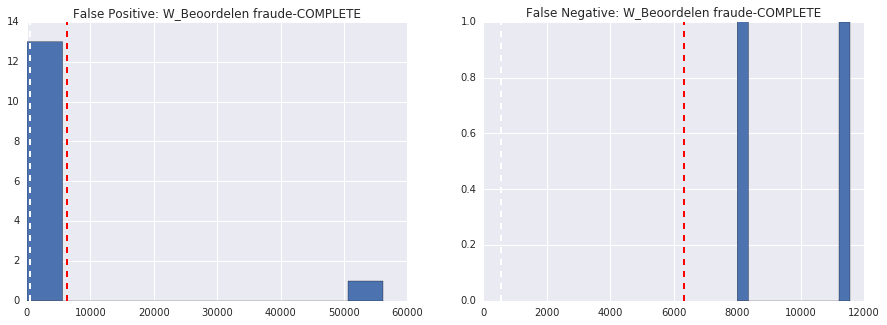

In [39]:
act_list = [i for i in submission_time['Activity'].unique()]
false_positive_df = submission_time[(submission_time['PredictedTimeLabel']== 1)&(submission_time['TimeLabel']== 0)]
false_negative_df = submission_time[(submission_time['PredictedTimeLabel']== 0)&(submission_time['TimeLabel']== 1)]

for act in act_list:
    plotFalseDuration(false_positive_df, false_negative_df, act, statistics_storage)

## Activity

In [40]:
error = np.mean(np.power(true_act - predicted_activity, 2), axis = 1)
error_activity_df = pd.DataFrame({'Error': error,
                                  'ActivityLabel': activity_label_test})

In [41]:
error_activity_df.head()

,ActivityLabel,Error
214377,0,0.024660
214378,0,0.024663
214379,0,0.024661
214380,1,0.026746
214381,0,0.025435


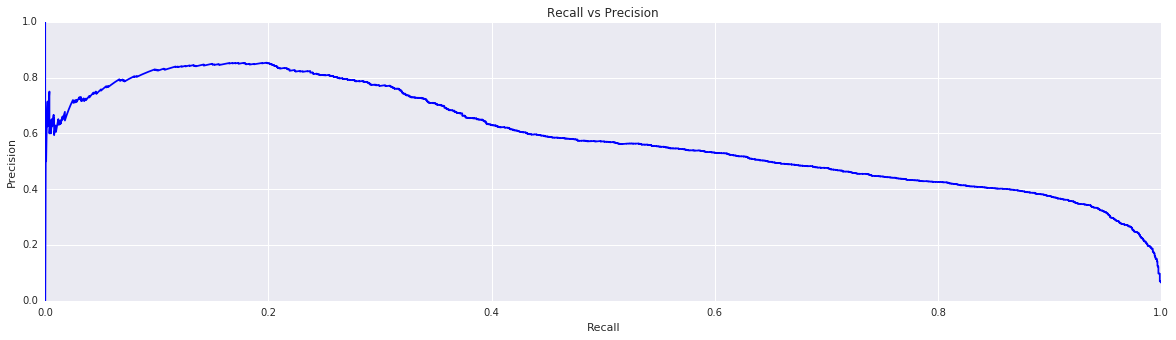

In [42]:
precision, recall, th = precision_recall_curve(error_activity_df.ActivityLabel, error_activity_df.Error, pos_label=1)
plt.figure(figsize=(20, 5))
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [43]:
activity_threshold = np.mean(error_activity_df['Error'])
print('Threshold of Activity: {}'.format(activity_threshold))

Threshold of Activity: 0.02549498350174186


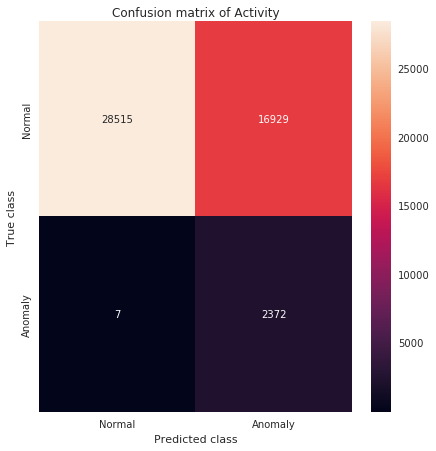

In [44]:
plotConfusionMaxtrix(error_activity_df, activity_threshold, variable='Activity')

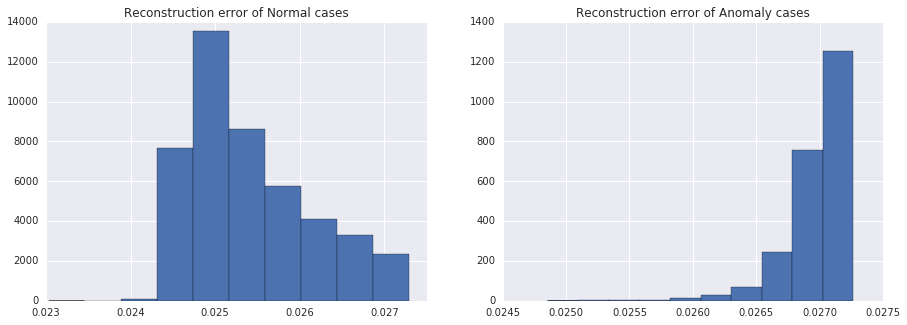

In [45]:
plotReconstructionError(error_activity_df)

In [46]:
evalScore(error_activity_df, activity_threshold, variable='Activity')

-------Evaluation of Activity-------


--Weighted Evaluation--
Evaluation of Activity
Precision: 0.96
Recall: 0.65
Fscore: 0.74


--Evaluation for each class--
Normal
Precision: 1.00
Recall: 0.63
Fscore: 0.77


Anomaly
Precision: 0.12
Recall: 1.00
Fscore: 0.22


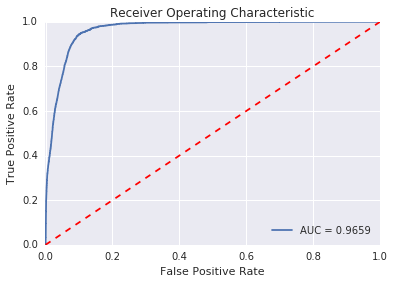

In [47]:
fpr, tpr, thresholds = roc_curve(error_activity_df.ActivityLabel, error_activity_df.Error, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [48]:
# evaluate based on classification
predicted_act_df = pd.DataFrame(data=predicted_activity, columns=list(true_act))
predicted_act_label = predicted_act_df.idxmax(axis=1)
true_act_label = true_act.idxmax(axis=1)
predicted_time_label = [0 if a==b else 1 for a, b in zip(true_act_label,predicted_act_label)]

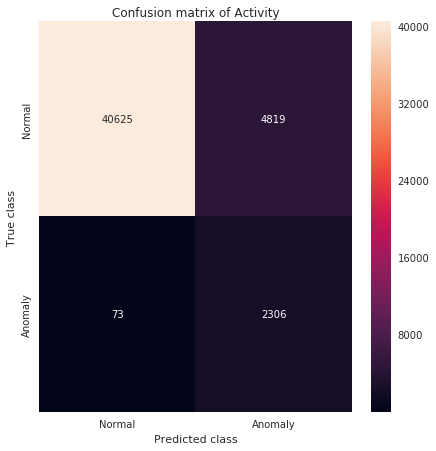

In [49]:
#plot confusion matrix
LABELS = ['Normal', 'Anomaly']
matrix = confusion_matrix(error_activity_df.ActivityLabel.astype('uint8'), predicted_time_label)
plt.figure(figsize=(7, 7))
sns.heatmap(matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title('Confusion matrix of Activity')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [50]:
score = precision_recall_fscore_support(error_activity_df.ActivityLabel.astype('uint8'), predicted_time_label, average='weighted')
    
print('-------Evaluation of Activity-------')
print('\n')
print('--Weighted Evaluation--')
print('Evaluation')
print('Precision: {:.2f}'.format(score[0]))
print('Recall: {:.2f}'.format(score[1]))
print('Fscore: {:.2f}'.format(score[2]))
print('\n')
score_1 = precision_recall_fscore_support(error_activity_df.ActivityLabel.astype('uint8'), predicted_time_label)
print('--Evaluation for each class--')
print('Normal')
print('Precision: {:.2f}'.format(score_1[0][0]))
print('Recall: {:.2f}'.format(score_1[1][0]))
print('Fscore: {:.2f}'.format(score_1[2][0]))
print('\n')
print('Anomaly')
print('Precision: {:.2f}'.format(score_1[0][1]))
print('Recall: {:.2f}'.format(score_1[1][1]))
print('Fscore: {:.2f}'.format(score_1[2][1]))

-------Evaluation of Activity-------


--Weighted Evaluation--
Evaluation
Precision: 0.96
Recall: 0.90
Fscore: 0.92


--Evaluation for each class--
Normal
Precision: 1.00
Recall: 0.89
Fscore: 0.94


Anomaly
Precision: 0.32
Recall: 0.97
Fscore: 0.49
